In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import yfinance as yf
import warnings
import mpl_finance as mpf
# from scipy import integrate
# from scipy.stats import t

from ipywidgets import widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive

import string

from IPython.display import Javascript, display, HTML
from ipywidgets import widgets

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
global ticker
global df
global new

@interact(Ticker = '')
def get_ticker(Ticker):
    global ticker
    global df
    ticker = Ticker

In [3]:
global slicer

def get_range(Period):
    global slicer
    
    if Period == "1-Day" : slicer = 83
    if Period == "1-Week" : slicer = 83 * 5
    if Period == "1-Month" : slicer = 83 * 5 * 4
    if Period == "3-Months" : slicer = 83 * 5 * 4 * 3
        
interact(get_range, Period=[('1-Day'), ('1-Week'), ('1-Month'), ('3-Months')]);

In [7]:
def run_all(ev):
    global ticker
    global df
    df = pd.read_csv(ticker + '.csv')
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="GO")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

In [8]:
short = 0
long = 0

### RSI
<p style="text-align: justify">The Relative Strength Index (RSI) is a well versed momentum based oscillator which is used to measure the speed (velocity) as well as the change (magnitude) of directional price movements.</p>

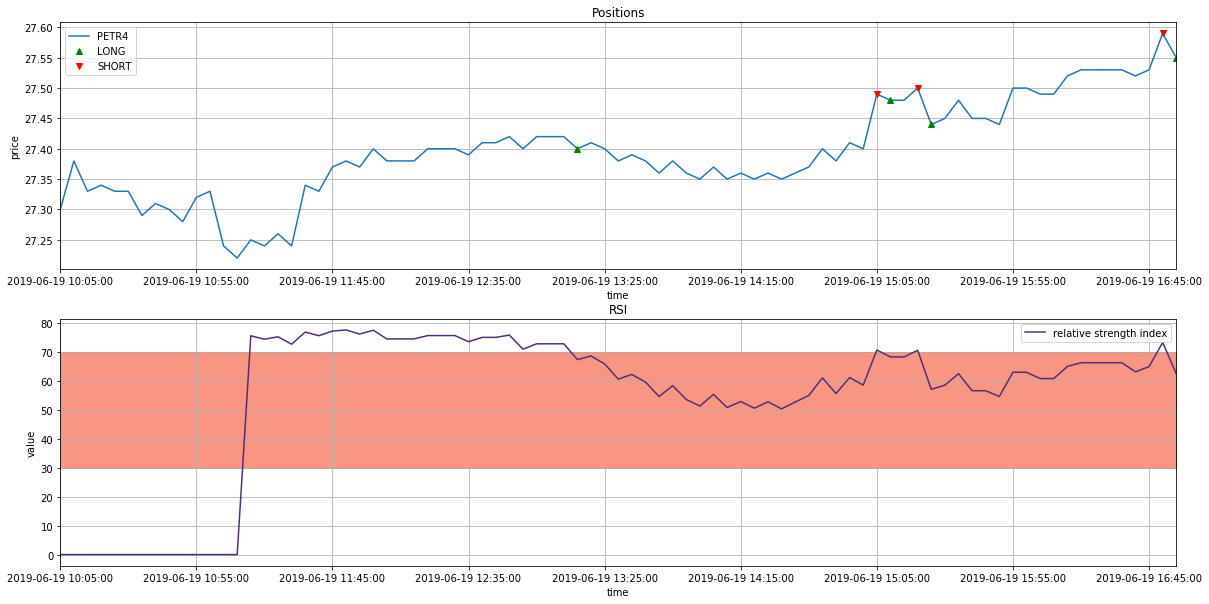

In [9]:
class rsi:
    def smma(series,n):

        output=[series[0]]

        for i in range(1,len(series)):
            temp=output[-1]*(n-1)+series[i]
            output.append(temp/n)

        return output
    
    def rsi(data,n):

        delta=data.diff().dropna()
        up=np.where(delta>0,delta,0)
        down=np.where(delta<0,-delta,0)
        rs=np.divide(rsi.smma(up,n),rsi.smma(down,n))
        output=100-100/(1+rs)

        return output[n-1:]

    def signal_generation(df,n):
        
        df['rsi']=0.0
        df['rsi'][n:] = rsi.rsi(df['close'],n)
        df['positions'] = np.select([df['rsi']<30,df['rsi']>70], [1,-1],default=0)
        df['signals'] = df['positions'].diff()

        return df

    def plot(new,ticker,n):

        fig = plt.figure(figsize=(20,10))
        
        ax1 = plt.subplot2grid((2,1), (0,0))
        new.set_index('time')['close'].plot(label=ticker)
        ax1.plot(new.loc[new['signals']==1].index,new['close'][new['signals']==1],label='LONG',lw=0,marker='^',c='g')
        ax1.plot(new.loc[new['signals']==-1].index,new['close'][new['signals']==-1],label='SHORT',lw=0,marker='v',c='r')

        plt.legend(loc='best')
        plt.grid(True)
        plt.title('Positions')
        plt.xlabel('time')
        plt.ylabel('price')

        ax2 = plt.subplot2grid((2,1), (1,0))
        new.set_index('time')['rsi'].plot(label='relative strength index',c='#522e75')
        ax2.fill_between(new.index,30,70,alpha=0.5,color='#f22f08')

        plt.xlabel('time')
        plt.ylabel('value')
        plt.title('RSI')
        plt.legend(loc='best')
        plt.grid(True)

    def main(): 
        global new
        new = new.reset_index()
        new = rsi.signal_generation(new, n=14)
        rsi.plot(new, ticker,n=14)

new = df[-slicer:].copy()
rsi.main()

In [10]:
indexSignalShort = new.loc[new['signals']<0].index
if len(indexSignalShort) > 0:
    indexSignalShort = indexSignalShort[-1]
else:
    indexSignalShort = -1

indexSignalLong = new.loc[new['signals']>0].index
if len(indexSignalLong) > 0:
    indexSignalLong = indexSignalLong[-1]
else:
    indexSignalLong = -1

if indexSignalShort > indexSignalLong:
    print("Last signal date:", new['time'][indexSignalShort])
    print("Last signal type: Short")
    short = short + 1
elif  indexSignalLong > indexSignalShort:
    print("Last signal date:", new['time'][indexSignalLong])
    print("Last signal type: Long")
    long = long + 1
else:
    print("Last signal date: N/A")
    print("Last signal type: N/A")

Last signal date: 2019-06-19 16:55:00
Last signal type: Long


### MACD
<p style="text-align: justify">Moving Average Convergence Divergence (MACD) is used to identify aspects of a security's overall trend. Most notably these aspects are momentum, as well as trend direction and duration.</p>

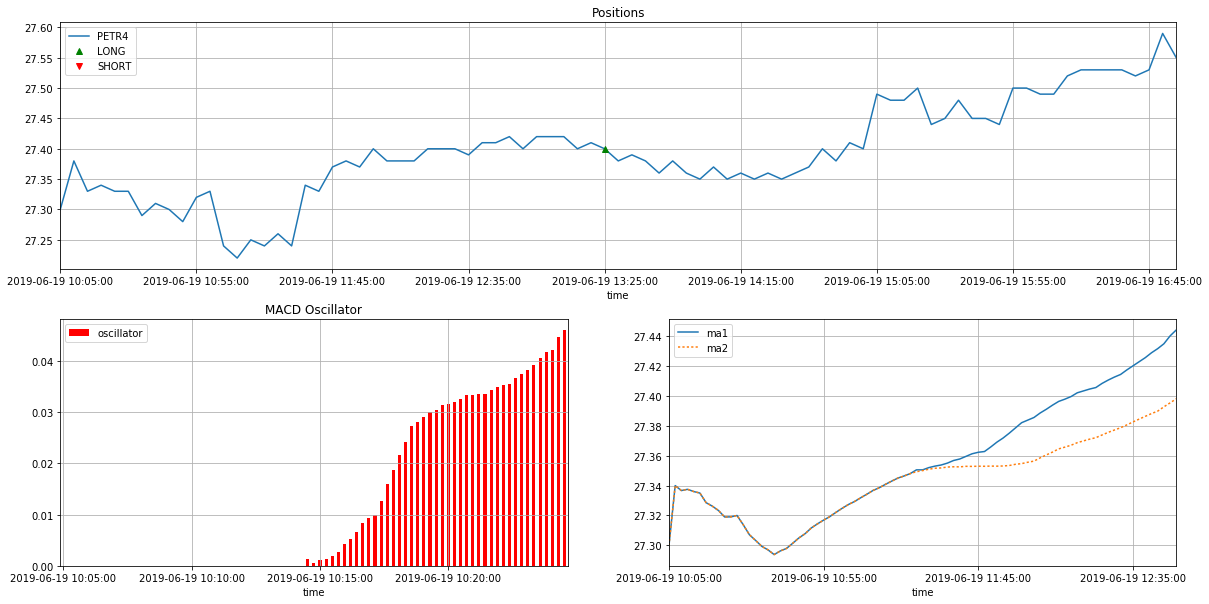

In [11]:
class macd:
    def macd(signals):
        
        signals['ma1']=signals['close'].rolling(window=ma1,min_periods=1,center=False).mean()
        signals['ma2']=signals['close'].rolling(window=ma2,min_periods=1,center=False).mean()

        return signals

    def signal_generation(df):

        signals=macd.macd(df)
        signals['positions']=0
        signals['positions'][ma1:]=np.where(signals['ma1'][ma1:]>=signals['ma2'][ma1:],1,0)
        signals['signals']=signals['positions'].diff()
        signals['oscillator']=signals['ma1']-signals['ma2']

        return signals

    def plot(new, ticker):

        fig = plt.figure(figsize=(20,10))

        ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
        new.set_index('time')['close'].plot(label=ticker)
        plt.plot(new.loc[new['signals']==1].index,new['close'][new['signals']==1],label='LONG',lw=0,marker='^',c='g')
        plt.plot(new.loc[new['signals']==-1].index,new['close'][new['signals']==-1],label='SHORT',lw=0,marker='v',c='r')
        plt.legend(loc='best')
        plt.grid(True)
        plt.title('Positions')

        ax2 = plt.subplot2grid((2,2), (1,0))
        new.set_index('time')['oscillator'].plot(kind='bar',color='r')

        plt.title('MACD Oscillator')
        plt.locator_params(axis='x', nbins=4)
        plt.xticks(rotation=0)
        plt.legend(loc='best')
        plt.grid(True)

        ax3 = plt.subplot2grid((2,2), (1,1))
        new.set_index('time')['ma1'].plot(label='ma1')
        new.set_index('time')['ma2'].plot(label='ma2',linestyle=':')
        
        plt.locator_params(axis='x', nbins=4)
        
        plt.legend(loc='best')
        plt.grid(True)

    def main(df, ticker):
        
        global new
        global ma1
        global ma2

        ma1=40
        ma2=80

        new = new.reset_index()
        new = macd.signal_generation(new)
        macd.plot(new, ticker)

new = df[-slicer:].copy()
macd.main(df, ticker)

In [12]:
indexSignalShort = new.loc[new['signals']<0].index
if len(indexSignalShort) > 0:
    indexSignalShort = indexSignalShort[-1]
else:
    indexSignalShort = -1

indexSignalLong = new.loc[new['signals']>0].index
if len(indexSignalLong) > 0:
    indexSignalLong = indexSignalLong[-1]
else:
    indexSignalLong = -1

if indexSignalShort > indexSignalLong:
    print("Last signal date:", new['time'][indexSignalShort])
    print("Last signal type: Short")
    short = short + 1
elif  indexSignalLong > indexSignalShort:
    print("Last signal date:", new['time'][indexSignalLong])
    print("Last signal type: Long")
    long = long + 1
else:
    print("Last signal date: N/A")
    print("Last signal type: N/A")

Last signal date: 2019-06-19 13:25:00
Last signal type: Long


### SAR
<p style="text-align: justify">Parabolic Stop and Reverse (SAR) is used to identify points of potential stops and reverses. It creates a parabola which is located below price during a Bullish Trend and above Price during a Bearish Trend.</p>

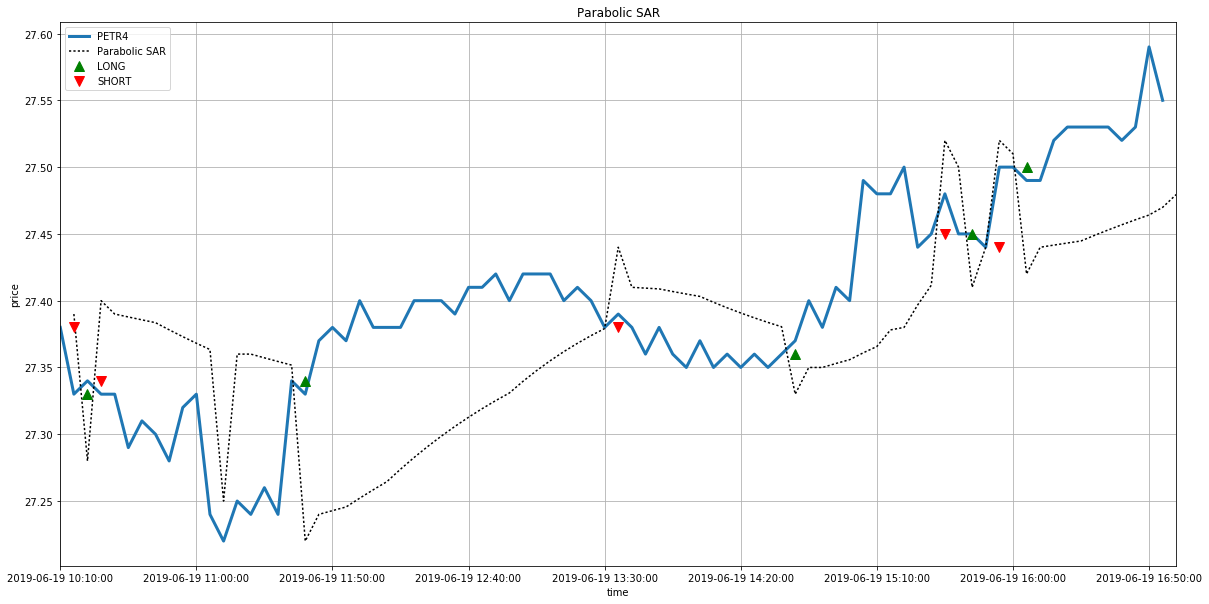

In [13]:
class parabolic_sar:
    def parabolic_sar(new):

        initial_af=0.02
        step_af=0.02
        end_af=0.2

        new['trend']=0
        new['sar']=0.0
        new['real sar']=0.0
        new['ep']=0.0
        new['af']=0.0
        new['trend'][1]=1 if new['close'][1]>new['close'][0] else -1
        new['sar'][1]=new['high'][0] if new['trend'][1]>0 else new['low'][0]
        new.at[1,'real sar']=new['sar'][1]
        new['ep'][1]=new['high'][1] if new['trend'][1]>0 else new['low'][1]
        new['af'][1]=initial_af

        for i in range(2,len(new)):

            temp=new['sar'][i-1]+new['af'][i-1]*(new['ep'][i-1]-new['sar'][i-1])
            if new['trend'][i-1]<0:
                new.at[i,'sar']=max(temp,new['high'][i-1],new['high'][i-2])
                temp=1 if new['sar'][i]<new['high'][i] else new['trend'][i-1]-1
            else:
                new.at[i,'sar']=min(temp,new['low'][i-1],new['low'][i-2])
                temp=-1 if new['sar'][i]>new['low'][i] else new['trend'][i-1]+1
            new.at[i,'trend']=temp


            if new['trend'][i]<0:
                temp=min(new['low'][i],new['ep'][i-1]) if new['trend'][i]!=-1 else new['low'][i]
            else:
                temp=max(new['high'][i],new['ep'][i-1]) if new['trend'][i]!=1 else new['high'][i]
            new.at[i,'ep']=temp


            if np.abs(new['trend'][i])==1:
                temp=new['ep'][i-1]
                new.at[i,'af']=initial_af
            else:
                temp=new['sar'][i]
                if new['ep'][i]==new['ep'][i-1]:
                    new.at[i,'af']=new['af'][i-1]
                else:
                    new.at[i,'af']=min(end_af,new['af'][i-1]+step_af)
            new.at[i,'real sar']=temp

        return new

    def signal_generation(df):

            new = parabolic_sar.parabolic_sar(df)

            new['positions'],new['signals']=0,0
            new['positions']=np.where(new['real sar']<new['close'],1,0)
            new['signals']=new['positions'].diff()

            return new

    def plot(new,ticker):

        fig = plt.figure(figsize=(20,10))

        ax1 = plt.subplot2grid((2,2), (0,0), colspan=2, rowspan=2)
        new.set_index('time')['close'].plot(lw=3,label='%s'%ticker)
        new['real sar'].plot(linestyle=':',label='Parabolic SAR',color='k')
        ax1.plot(new.loc[new['signals']==1].index,new['close'][new['signals']==1],marker='^',color='g',label='LONG',lw=0,markersize=10)
        ax1.plot(new.loc[new['signals']==-1].index,new['close'][new['signals']==-1],marker='v',color='r',label='SHORT',lw=0,markersize=10)

        plt.legend(loc='best')
        plt.grid(True)
        plt.title('Parabolic SAR')
        plt.ylabel('price')
        plt.show()

    def main(df, ticker):

        global new
        
        new = new.reset_index()
        new = parabolic_sar.signal_generation(new)    
        parabolic_sar.plot(new[1:],ticker)

new = df[-slicer:].copy()   
parabolic_sar.main(df, ticker)

In [14]:
indexSignalShort = new.loc[new['signals']<0].index
if len(indexSignalShort) > 0:
    indexSignalShort = indexSignalShort[-1]
else:
    indexSignalShort = -1

indexSignalLong = new.loc[new['signals']>0].index
if len(indexSignalLong) > 0:
    indexSignalLong = indexSignalLong[-1]
else:
    indexSignalLong = -1

if indexSignalShort > indexSignalLong:
    print("Last signal date:", new['time'][indexSignalShort])
    print("Last signal type: Short")
    short = short + 1
elif  indexSignalLong > indexSignalShort:
    print("Last signal date:", new['time'][indexSignalLong])
    print("Last signal type: Long")
    long = long + 1
else:
    print("Last signal date: N/A")
    print("Last signal type: N/A")

Last signal date: 2019-06-19 16:00:00
Last signal type: Long


### Heikin-Ashi Candlesticks
<p style="text-align: justify">This is a Japonese method based on price data from the current price, the current Heikin-Ashi values, and the prior Heikin-Ashi values. These candlesticks are used to identify trending periods and potential reversal points.</p>

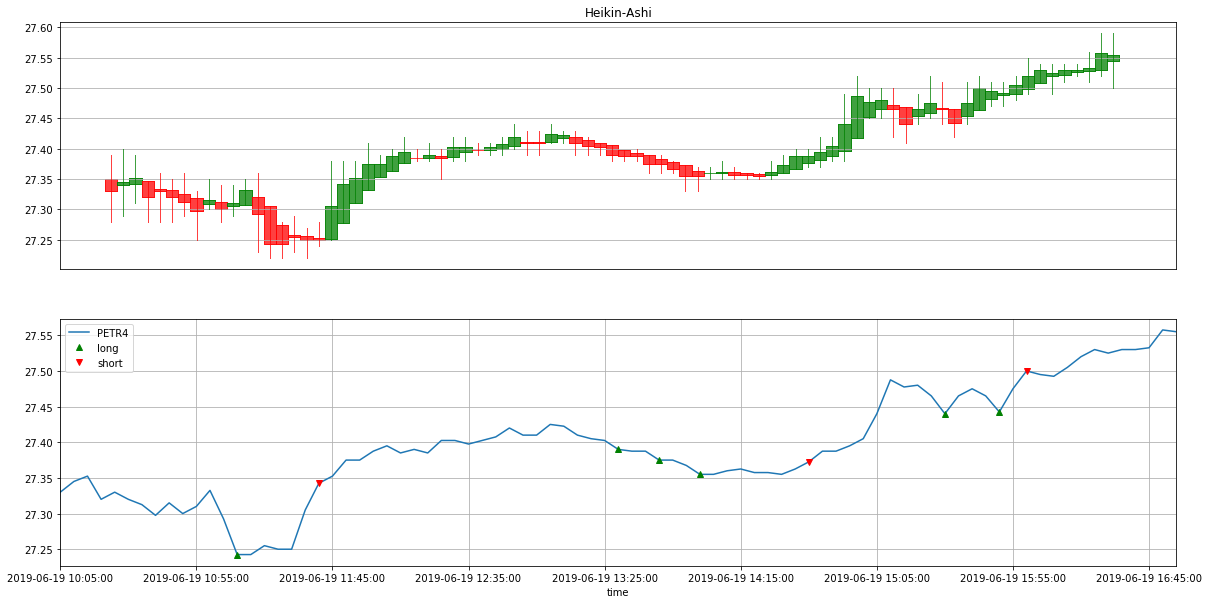

In [15]:
class heikin_ashi:
    def heikin_ashi(df1):

        df1.reset_index(inplace=True)

        df1['HA close']=(df1['open']+df1['close']+df1['high']+df1['low'])/4
        df1['HA open']=float(0)
        df1['HA open'][0]=df1['open'][0]

        for n in range(1,len(df1)):
            df1.at[n,'HA open']=(df1['HA open'][n-1]+df1['HA close'][n-1])/2

        temp=pd.concat([df1['HA open'],df1['HA close'],df1['low'],df1['high']],axis=1)
        df1['HA high']=temp.apply(max,axis=1)
        df1['HA low']=temp.apply(min,axis=1)

        del df1['close']
        del df1['volume']
        return df1

    def signal_generation(df,stls):

        df1 = heikin_ashi.heikin_ashi(df)

        df1['signals']=0
        df1['cumsum']=0

        for n in range(1,len(df1)):

            if (df1['HA open'][n]>df1['HA close'][n] and df1['HA open'][n]==df1['HA high'][n] and
                np.abs(df1['HA open'][n]-df1['HA close'][n])>np.abs(df1['HA open'][n-1]-df1['HA close'][n-1]) and
                df1['HA open'][n-1]>df1['HA close'][n-1]):

                df1.at[n,'signals']=1
                df1['cumsum']=df1['signals'].cumsum()

                if df1['cumsum'][n]>stls:
                    df1.at[n,'signals']=0


            elif (df1['HA open'][n]<df1['HA close'][n] and df1['HA open'][n]==df1['HA low'][n] and 
            df1['HA open'][n-1]<df1['HA close'][n-1]):

                df1.at[n,'signals']=-1
                df1['cumsum']=df1['signals'].cumsum()

                if df1['cumsum'][n]>0:
                    df1.at[n,'signals']=-1*(df1['cumsum'][n-1])

                if df1['cumsum'][n]<0:
                    df1.at[n,'signals']=0

        return df1

    def plot(df1,ticker):

        fig = plt.figure(figsize=(20,10))

        ax1 = plt.subplot2grid((2,1), (0,0))
        mpf.candlestick2_ochl(ax1, df1['HA open'], df1['HA close'], df1['HA high'], df1['HA low'], width=1, colorup='g', colordown='r')
        plt.grid(True)
        plt.xticks([])
        plt.title('Heikin-Ashi')

        ax2 = plt.subplot2grid((2,1), (1,0))
        df1.set_index('time')['HA close'].plot(ax=ax2,label=ticker)
        ax2.plot(df1.loc[df1['signals']==1].index,df1['HA close'][df1['signals']==1],marker='^',lw=0,c='g',label='long')
        ax2.plot(df1.loc[df1['signals']<0].index,df1['HA close'][df1['signals']<0],marker='v',lw=0,c='r',label='short')

        plt.grid(True)
        plt.legend(loc='best')
        plt.show()

    def omega(risk_free,degree_of_freedom,maximum,minimum):

        y=integrate.quad(lambda g:1-t.cdf(g,degree_of_freedom),risk_free,maximum)
        x=integrate.quad(lambda g:t.cdf(g,degree_of_freedom),minimum,risk_free)
        z=(y[0])/(x[0])

        return z

    def sortino(risk_free,degree_of_freedom,growth_rate,minimum):

        v=np.sqrt(np.abs(integrate.quad(lambda g:((risk_free-g)**2)*t.pdf(g,degree_of_freedom),risk_free,minimum)))
        s=(growth_rate-risk_free)/v[0]

        return s

    def mdd(series):

        temp=0
        for i in range(1,len(series)):
            if temp>(series[i]/max(series[:i])-1):
                temp=(series[i]/max(series[:i])-1)

        return temp

    def main(df, ticker):

        global new
        
        new = df[-slicer:].copy()
        stls = 3
        new = heikin_ashi.signal_generation(new,stls)
        heikin_ashi.plot(new,ticker)

new = df[-slicer:].copy()
heikin_ashi.main(df, ticker)

In [16]:
indexSignalShort = new.loc[new['signals']<0].index
if len(indexSignalShort) > 0:
    indexSignalShort = indexSignalShort[-1]
else:
    indexSignalShort = -1

indexSignalLong = new.loc[new['signals']>0].index
if len(indexSignalLong) > 0:
    indexSignalLong = indexSignalLong[-1]
else:
    indexSignalLong = -1

if indexSignalShort > indexSignalLong:
    print("Last signal date:", new['time'][indexSignalShort])
    print("Last signal type: Short")
    short = short + 1
elif  indexSignalLong > indexSignalShort:
    print("Last signal date:", new['time'][indexSignalLong])
    print("Last signal type: Long")
    long = long + 1
else:
    print("Last signal date: N/A")
    print("Last signal type: N/A")

Last signal date: 2019-06-19 16:00:00
Last signal type: Short


#### Ticker Sumary

In [32]:
str0 = "<h2>Ticker: " + str(ticker) + "</h2>" 
str1 = "<h2>Last price: " + str(df['close'].iloc[-1]) + "</h2>" 
display(HTML(str0))
display(HTML(str1))

#### Trade Grade

In [19]:
if short > long:
    print("Short ", ticker, " with grade: ", short, " Short / ", long, " Long")
elif long > short:
    print("Long ", ticker, " with grade: ", long, " Long / ", short, " Short")
else:
    print("Neutral position for ", ticker, " with grade: ", long, " Long / ", short, " Short")

Long  PETR4  with grade:  3  Long /  1  Short
